# Steam Game Recommender
#### Capstone Project, Machine Learning Engineer Nanodegree

## Project Overview
Steam is a gaming platform where multiple games on different platforms (including PC, Mac, and Linux) are sold to players. It also has a social component including streaming and community forums. Many video game providers also hold frequent discounts on the offered games. Users can also see recommendations based on the games they have played already.

Improving the recommendations shown to a user can increase user engagement and increase revenue of the game producer (and Steam too). Given the huge variety of games available across various platforms, targeting the correct user who is likely to buy the game, conduct micro-transactions, and/or recommend the game to his friends is a very lucrative problem for game producers. Since Steam receives a cut on games sold through Steam, Valve also has an interest in properly recommending games.

## Problem Statement

Create a recommendation system which can predict user engagement with games (the scoring function which is defined below) given playtime data about the games and the user. Top-5 games will be recommended to the user along with the predicted score (defined above). This score can be used by companies to decide revenues. Eg. If a user plays a game (eg Candy Crush) very much as compared to other players, similar long-term games with micro-transactions can be suggested to him. On the other hand, if a user plays a lot of different games but doesn’t spend a lot of time on any of them, another variety of games with one-time prices can be shown to him. 


## Scoring Function

A scoring function will be defined to incorporate the wide range in hours played across different users and different games. This will be an attempt to reduce skew and normalise the given data.

$ score = personal \ ratio * normalised \ hours $

Example
If user XYZ has played game A for 20 hours and he has totally played 100 hours on Steam:

$ personal \ ratio = \frac{20}{100} = 0.2 $

But what if game A is a singleplayer campaign which only lasts around 10 hours? Then user XYZ seems to like game A a lot compared to other players. It is assumed that the players playing game A are normally distributed.
If game A is distributed with a mean of 10 hours and a standard deviation of 5 hours, 
$ normalised \ hours = \frac{20-10}{5} = 2 $

$ score = 0.2 * 2 = 0.4 $

## Datasets
- [Steam Video Games dataset](https://www.kaggle.com/tamber/steam-video-games)

This dataset provided by [Tamber](https://tamber.com/) contains user playtime data for different Steam games, ie the hours a particular user has played a particular game.

To quote the content description from the Kaggle page - “This dataset is a list of user behaviors, with columns: user-id, game-title, behavior-name, value. The behaviors included are 'purchase' and 'play'. The value indicates the degree to which the behavior was performed - in the case of 'purchase' the value is always 1, and in the case of 'play' the value represents the number of hours the user has played the game.”

- [Internet Game Database API](https://www.igdb.com/api)

Instead of using DBPedia as planned in the original capstone proposal, the Internet Game Database API was used since it contained detailed game information and had a good API as compared to DBPedia which would have heavy SPARQL queries.


## Evaluation Metrics
Instead of using “Precision at N” as used by [Kevin Wong](http://www.nextvideogame.com/methodology.html#evaluation), an RMSE(Root Mean Squared Error) score will be used since the predicted score is more important in this case than just predicting whether the game is played or not. Eg. Suggesting “Candy Crush” to a player who plays such micro-transaction games for a long time (and pays for the in game boosts) will generate more revenue than suggesting a game which has a small one time price. 


## Proposed Solution

Collaborative filtering (explained below) will be used to fill in the missing user-game score matrix. The top 5 games (arranged in order of descending scores) will then be chosen and shown to the user as recommendations. Matrix factorization will be used to characterise the latent features between users and games. Since game data is also available (from IGDB) factorisation machine models will also be used to improve performance.

Since explicit data is available (in the form of the defined scores), a [factorisation Recommender](https://turi.com/products/create/docs/generated/graphlab.recommender.factorization_recommender.create.html) will be used as suggested [here](https://timchen1.gitbooks.io/graphlab/content/recommender/choosing-a-model.html). Note : An item similarity recommender will not be used since it can not incorporate user and game specific information (as noted in the relevant documentation Notes section). Parameter tuning will then be done to improve performance. 

### Collaborative Filtering
| Player | Civ 5 | Empire TW | EU IV | CS GO | CoD MW2 | Candy Crush | 
| -- | -- | -- | -- | -- | -- | -- |
| A | 5 | 4 | ?? | ?? | 1 | ?? |
| B | 4 | 5 | 5 | 1 | 1 | ?? |
| C | 2 | 1 | 3 | 5 | 4 | ?? |
| D | ?? | ?? | ?? | ?? | ?? | 5 |

| Genre | Game Code | Full Form | 
| -- | -- | -- |
| Strategy | Civ 5 | Sid Meier’s Civilisation 5 |
| Strategy | Empire TW | Empire Total War |
| Strategy | EU IV | Europa Universalis IV |
| First-player Shooter | CS GO | Counter Strike GO |
| First-player Shooter | CoD MW2 |  Call of Duty : Modern Warfare 2 |
| Mobile | Candy Crush | Candy Crush |
Suppose we want to predict games for player A based on the above table. The scores range from 1-5 (with 5 being the highest) and a '??' denotes that the player hasn't played the game.

Player A can have roughly 3 kinds of correlations with other players:
1. Positive Correlation - Player A and player B have high scores for strategy games and low scores for first player shooters. Therefore based on player B, we’ll suggest EU IV to A but we won’t suggest CS Go.

2. Negative Correlation - Player A and player C have the opposite tastes. C likes first player shooters but doesn’t like strategy games. It is the opposite with player A. Therefore based on player C, we won’t suggest the games C likes to player A.

3. Zero Correlation - Player D only likes mobile games and has no ratings about other games. Therefore, player D’s ratings won’t be used to suggest any games to A.

This is called collaborative filtering where the system finds users with similar tastes as the target user and then recommends items which those users have used (but the target user hasn’t). The correlation coefficients for different players can be input to learning algorithms to create predictions for player A.

#### Adding genre information
It is likely that a player who plays strategy games like Sid Meier's Civilization V will also be interested in playing Empire Total War. Similarly, a player who plays multiplayer first-person shooters like Counter-Strike Global Offensive a lot may also want to play Call of Duty Modern Warfare 2. So the playtime data available is supplemented by adding genre information from IGDB. 


## Benchmark
There are 40 million player-game interactions possible in this dataset. But only 70,000 interactions are present in the entire dataset (even before splitting into train-CV-test). Due to this sparsity (0.17% filled entries), it is likely that a simpler model may perform better than an advanced model. As a benchmark, a simple popularity recommender will be used which will just use the average of the scores as the output. It is not tailored to individuals and won’t use the genre data.


$ 3,500 \ games * 11,350 \ players = 40,860,000 \ interactions $

## Data Preprocessing

The dataset provided by Tamber had 200,000 interactions out of which only 70,489 interactions contained playtime data. Out of these 70,489 interactions, there were duplicate entries for 12 player-games. The duplicate entries were removed and only the last occurrences were kept.


In [1]:
import pandas as pd

In [2]:
rawdata = pd.read_csv('data/steam-200k.csv',header=None,
                      names=['user-id','game-title','behavior-name','hours','null'])
rawdata[:5]

,user-id,game-title,behavior-name,hours,null
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


This dataset is a list of user behaviors, with columns: user-id, game-title, behavior-name, hours and null. The behaviors included are 'purchase' and 'play'. The value in the 'hours' column indicates the degree to which the behavior was performed - in the case of 'purchase' the value is always 1, and in the case of 'play' the value represents the number of hours the user has played the game.

Since only playtime data is required, the rows which have the 'purchase' behavior are removed.

In [3]:
playtimedata=rawdata[rawdata['behavior-name']=='play']
playtimedata.drop(['behavior-name','null'],axis=1,inplace=True)
playtimedata[:5]

/home/rahulhp/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,user-id,game-title,hours
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9
7,151603712,Fallout New Vegas,12.1
9,151603712,Left 4 Dead 2,8.9


### Removing duplicate rows
In the dataset, 12 user-game interactions have 2 values.

In [4]:
duplicates = playtimedata.groupby(['user-id','game-title']).count().reset_index()
duplicates[duplicates['hours']>1]

,user-id,game-title,hours
8827,28472068,Grand Theft Auto III,2
8829,28472068,Grand Theft Auto San Andreas,2
8830,28472068,Grand Theft Auto Vice City,2
11066,33865373,Sid Meier's Civilization IV,2
18414,50769696,Grand Theft Auto San Andreas,2
22653,59925638,Tom Clancy's H.A.W.X. 2,2
27873,71411882,Grand Theft Auto III,2
27944,71510748,Grand Theft Auto San Andreas,2
43939,118664413,Grand Theft Auto San Andreas,2
51079,148362155,Grand Theft Auto San Andreas,2


We are keeping only the last value in this case.

In [5]:
playtimedata.drop_duplicates(subset=['user-id','game-title'],keep='last',inplace=True)

/home/rahulhp/anaconda2/envs/gl-env/lib/python2.7/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


## Adding genre and developer information

Since there are 3600 games and the API had a rate limitation of 7000 queries per day, the following code which queries the API for genre + developer information has been commented out. The results have been stored in a pickle file for later usage. The API key has also been removed for privacy reasons. The API key can be obtained from the [Mashape website](https://market.mashape.com/igdbcom/internet-game-database)

In [6]:
import requests
import sys
import pickle

This helper function was used to get the developer and genre information

In [7]:
def get_game_data(search_string):
    API_URL = "https://igdbcom-internet-game-database-v1.p.mashape.com/games/?"
    FIELDS = "fields=name%2Cslug%2Cdevelopers%2Cgenres&limit=1&offset=0&search="
    
    search_url = API_URL + FIELDS + search_string
    headers={
        "X-Mashape-Key": "INSERT-KEY-HERE",
        "Accept": "application/json"
      }
    try:
        r = requests.get(search_url,headers=headers)
        d = dict()
        d['name'] = search_string
        d['developers'] = r.json()[0].get(['developers'][0],0)
        d['genres'] = r.json()[0].get(['genres'][0],0)
        return d
    except:
        print "\tUnexpected error: "+str(sys.exc_info()[0])
        return None

The below code has which called the API for the games been disabled.

In [8]:
gameinfo = pickle.load(open("gameinfo.p","rb"))

Example output from the API:

In [9]:
print gameinfo[12]

{'genres': [12, 31], 'developers': [1243], 'name': 'The Incredible Adventures of Van Helsing III'}


In [10]:
genres = set()
for game in gameinfo:
    if type(game['genres'])==list:
        for i in game['genres']:
            genres.add(i)
print len(genres)

20


There are 20 distinct genres present in the dataset.

In [11]:
developers = set()
for game in gameinfo:
    if type(game['developers'])==list:
        for i in game['developers']:
            developers.add(i)
print len(developers)

1858


There are 1858 distinct developers. Since there are 3600 games in the dataset, on average each developer has made 2 games. Due to the very sparse data in this field, this field has been removed from future calculations. Only the genre information will be used.

### Removing extra games from playtimedata

In [12]:
print len(gameinfo)

3581


Information for only 3581 games was obtained from IGDB. We'll be removing the data for the other 19 games before proceeding.

In [13]:
igdbgames = set([i['name'] for i in gameinfo])
tambergames = set(playtimedata['game-title'].unique())

print 'Data from these 19 games was unavailable: ' + ' '.join(x for x in list(tambergames.difference(igdbgames)))

Data from these 19 games was unavailable: Batla Dethroned! Voxelized Aberoth Jumpdrive Deepworld Squirreltopia Breezeblox Cosmophony Rexaura Immune KWAAN CRYENGINE Burstfire Unium ROCKETSROCKETSROCKETS Rotieer Alganon Motorbike


A right join is used to keep only those games which occur in the IGDB dataset.

In [14]:
igdbgamesDF = pd.DataFrame({'game-title':[i['name'] for i in gameinfo]})
finalplaytimedata = pd.merge(playtimedata,igdbgamesDF,how='right')

### Creating a game information table
Since only the genre information is being used, basic one-hot encoding is used to create the item data table. This dataframe is used in the factorisation recommender.

In [15]:
genrelist = list()
for i in gameinfo:
    genrelist.append({'genres':i['genres'],'game-title':i['name']})
genreDF = pd.DataFrame(genrelist)

genre_encoded = pd.get_dummies(genreDF['genres'].apply(pd.Series).stack(),prefix='genre').sum(level=0)

genre_dummies = pd.concat([genreDF,genre_encoded],axis=1).drop('genres',axis=1)
genre_dummies[:3]

,game-title,genre_0.0,genre_2.0,genre_4.0,genre_5.0,genre_7.0,genre_8.0,genre_9.0,genre_10.0,genre_11.0,...,genre_14.0,genre_15.0,genre_16.0,genre_24.0,genre_25.0,genre_26.0,genre_30.0,genre_31.0,genre_32.0,genre_33.0
0,10 Second Ninja,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Toy Soldiers War Chest,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Infestation Survivor Stories,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Exploratory Data Analysis

### Player Data

In [39]:
userdata=finalplaytimedata[['user-id','game-title']].groupby('user-id').count().reset_index() \
.rename(columns={'game-title':'games-played'}).sort_values(by='games-played',ascending=False)

print len(userdata)
userdata[:5]


11350


,user-id,games-played
1478,62990992,496
175,11403772,314
4506,138941587,298
989,47457723,297
1070,49893565,297


In [24]:
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

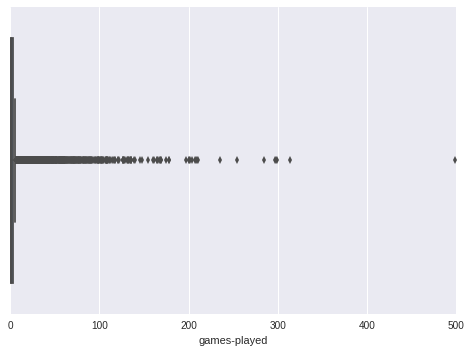

In [28]:
sns.boxplot(userdata['games-played'])

There are 11350 unique players in this dataset. But as seen in the boxplot, there are a lot of extreme players in this dataset but a majority of the players (~80%) have played less than 5 games.

In [30]:
userdata['games-played'].mean()

6.209427312775331

In [31]:
userdata['games-played'].std()

17.75490607377872

In [154]:
userdata['games-played'].median()

1.0

In [32]:
for threshold in [1,5,10,25,50,100,250,500]:
    playercount = len(userdata[userdata['games-played']<=threshold])
    playerpercent = 100.0*playercount/len(userdata)
    print 'Number of players with <= %4d games: %5d (%3.0f%%)' % (threshold, playercount, playerpercent)

Number of players with <=    1 games:  6559 ( 58%)
Number of players with <=    5 games:  9221 ( 81%)
Number of players with <=   10 games:  9978 ( 88%)
Number of players with <=   25 games: 10753 ( 95%)
Number of players with <=   50 games: 11069 ( 98%)
Number of players with <=  100 games: 11267 ( 99%)
Number of players with <=  250 games: 11343 (100%)
Number of players with <=  500 games: 11350 (100%)


### Game Data

In [42]:
gamedata=finalplaytimedata[['user-id','game-title']].groupby('game-title').count().reset_index()\
.rename(columns={'user-id':'players'}).sort_values('players',ascending=False)

print len(gamedata)

3581


In [43]:
gamedata['percent'] = 100*gamedata['players']/sum(gamedata['players'])
top10=gamedata[:10]
top10

,game-title,players,percent
913,Dota 2,4841,6.873394
2977,Team Fortress 2,2323,3.298264
666,Counter-Strike Global Offensive,1377,1.955105
3332,Unturned,1069,1.517798
1721,Left 4 Dead 2,801,1.137283
668,Counter-Strike Source,715,1.015178
3050,The Elder Scrolls V Skyrim,677,0.961224
1304,Garry's Mod,666,0.945606
663,Counter-Strike,568,0.806463
2675,Sid Meier's Civilization V,554,0.786585


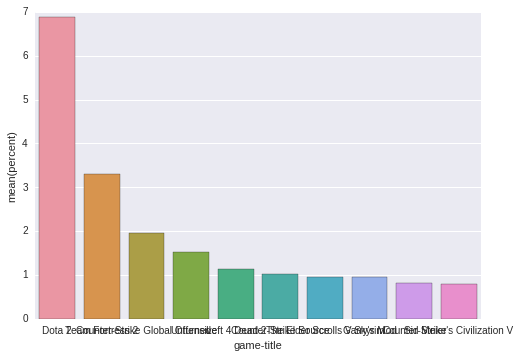

In [44]:
sns.barplot(x="game-title",y="percent",data=top10)

In [47]:
for threshold in [10,50,100,200,500,5000]:
    playercount = len(gamedata[gamedata['players']<=threshold])
    playerpercent = 100.0*playercount/len(gamedata)
    print 'Number of games with <= %4d players: %5d (%3.2f%%)' % (threshold, playercount, playerpercent) 

Number of games with <=   10 players:  2593 (72.41%)
Number of games with <=   50 players:  3297 (92.07%)
Number of games with <=  100 players:  3448 (96.29%)
Number of games with <=  200 players:  3541 (98.88%)
Number of games with <=  500 players:  3571 (99.72%)
Number of games with <= 5000 players:  3581 (100.00%)


The distribution of players is very uneven. DOTA 2 has double the players as the next game TF2. Only 6 games have more than 1% of the players in this dataset.

## Genre data

In [73]:
combine=pd.merge(gamedata,genre_dummies,on='game-title')

In [76]:
genregamecount=genre_dummies.filter(regex='genre').sum(axis=0)

In [77]:
genreplayercount=combine.filter(regex='genre').mul(combine['players'],axis=0).sum(axis=0)

In [88]:
genrecombined=pd.DataFrame({'games':genregamecount,'players':genreplayercount})

In [91]:
genrecombined['avg-players']=genrecombined['players']/genrecombined['games']

In [101]:
genrecombined.sort('games')

/home/rahulhp/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,games,players,avg-players
genre_30.0,1.0,1.0,1.000000
genre_26.0,6.0,14.0,2.333333
genre_7.0,28.0,316.0,11.285714
genre_4.0,62.0,1908.0,30.774194
genre_14.0,101.0,1281.0,12.683168
genre_25.0,124.0,2964.0,23.903226
genre_16.0,130.0,2463.0,18.946154
genre_10.0,140.0,2381.0,17.007143
genre_24.0,147.0,11998.0,81.619048
genre_33.0,157.0,1667.0,10.617834


Genre 24 (Tactical games) has only 147 games but it has the highest average players per game. This is because DOTA 2 (the most popular game) falls in this genre.

## Scoring Function

Since a score was the target variable, it has to be created for the whole dataset together (since we needed scores for the test interactions too). But to avoid this test data from leaking into the training data, the scores for the training data were also calculated separately. 

A separate create_score() function was created for this function. Splitting the dataset properly so that no leakage occurred was a major issue during this step. Sanity checks and debugging statements were used at each step to ensure that the correct number of rows existed at each step.

![][scoring]

[scoring]: Scoring.jpg

In [102]:
import graphlab as gl

In [104]:
playtimedataSF = gl.SFrame(finalplaytimedata)
genreSF = gl.SFrame(genre_dummies)

In [105]:
def create_score(dataset):
    #print 'Creating scores.'
    #print "There are " + str(dataset.shape[0]) + " interactions in this dataset."
    totalhours=dataset.groupby(key_columns='user-id',operations={'total_hours':gl.aggregate.SUM('hours')})
    #print "There are " + str(totalhours.shape[0]) + " unique users in this dataset."
    
    hoursjoined = dataset.join(totalhours,on='user-id')
    hoursjoined['personal-ratio']=hoursjoined['hours']/hoursjoined['total_hours']
    hoursjoined.remove_columns(['hours','total_hours'])
    #print "There are " + str(hoursjoined.shape[0]) + " interactions in the personal-ratio dataset."
    
    gamedist=dataset.groupby(key_columns='game-title',operations={'hours-avg':gl.aggregate.MEAN('hours'),
                                                           'hours-std':gl.aggregate.STD('hours')})
    #print "There are " + str(gamedist.shape[0]) + " unique games in this dataset."
    
    playerdist = dataset.join(gamedist,on='game-title')
    playerdist['normalised-ratio']=(playerdist['hours']-playerdist['hours-avg'])/playerdist['hours-std']
    playerdist = playerdist.fillna('normalised-ratio',0)
    playerdist.remove_columns(['hours','hours-std','hours-avg'])
    
    #print "There are " + str(playerdist.shape[0]) + " interactions in the player-distribution dataset."
    
    joined = playerdist.join(hoursjoined)
    joined['score']=joined['normalised-ratio']*joined['personal-ratio']
    joined.remove_columns(['normalised-ratio','personal-ratio'])
    #print "There are " + str(joined.shape[0]) + " scores in the final scoring dataset."
    return joined

In [106]:
train, other = gl.recommender.util.random_split_by_user(playtimedataSF,user_id='user-id',item_id='game-title',random_seed=12)
print train.shape
print other.shape

(69232, 3)
(1199, 3)


In [107]:
train_score = create_score(train)

whole_score = create_score(playtimedataSF)

other_score = other.join(whole_score,how='left')
other_score = other_score.remove_column('hours')
cv_score,test_score = gl.recommender.util.random_split_by_user(other_score,user_id='user-id',item_id='game-title',random_seed=12)

print train_score.shape
print cv_score.shape
print test_score.shape

(69232, 3)
(970, 3)
(229, 3)


## Benchmark model

A basic popularity recommender is created. This will be used as the benchmark model and the factorisation recommender performance will be compared to this model.

In [108]:
basemodel = gl.recommender.popularity_recommender.create(train_score,user_id='user-id'
                                                         ,item_id='game-title',target='score')

Recsys training: model = popularity

Preparing data set.

Data has 69232 observations with 11221 users and 3558 items.

Data prepared in: 0.316876s

69232 observations to process; with 3558 unique items.

In [109]:
gl.evaluation.rmse(basemodel.predict(cv_score), cv_score['score'])

0.4796248793464026

The popularity recommender has an RMSE of 0.479 on the cross validation data.

## Factorisation Recommender

In [110]:
simplemodel = gl.recommender.factorization_recommender.create(train_score,user_id='user-id',item_id='game-title',target='score',item_data=genreSF)

Recsys training: model = factorization_recommender

Preparing data set.

Data has 69232 observations with 11221 users and 3581 items.

Data prepared in: 0.250445s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-08    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 69232 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 2.17391           | Not Viable                               |

| 1       | 0.543478          | Not Viable                               |

| 2       | 0.13587           | Not Viable                               |

| 3       | 0.0339674         | 0.15806                                  |

| 4       | 0.0169837         | 0.174171                                 |

| 5       | 0.00849185        | 0.193037                                 |

| 6       | 0.00424592        | 0.199002                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0339674         | 0.15806                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 195us        | 0.232142          | 0.481811              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 333.179ms    | 0.457293          | 0.676228              | 0.0339674   |

| 2       | 688.785ms    | DIVERGED          | DIVERGED              | 0.0339674   |

| RESET   | 781.723ms    | 0.232142          | 0.481811              |             |

| 1       | 1.14s        | 0.233856          | 0.483586              | 0.0169837   |

| 2       | 1.47s        | 0.227827          | 0.477311              | 0.0169837   |

| 3       | 1.91s        | 0.230452          | 0.480053              | 0.0169837   |

| 4       | 2.19s        | 0.434907          | 0.659473              | 0.0169837   |

| 5       | 2.53s        | DIVERGED          | DIVERGED              | 0.0169837   |

| RESET   | 2.60s        | 0.232143          | 0.481812              |             |

| 1       | 2.90s        | 0.232859          | 0.482555              | 0.00849185  |

| 3       | 3.46s        | 0.226978          | 0.476422              | 0.00849185  |

| 6       | 4.47s        | 0.22236           | 0.47155               | 0.00849185  |

| 8       | 5.06s        | 0.220761          | 0.469852              | 0.00849185  |

| 13      | 6.38s        | 0.235932          | 0.485727              | 0.00849185  |

| 16      | 7.39s        | DIVERGED          | DIVERGED              | 0.00849185  |

| RESET   | 7.46s        | 0.23214           | 0.481809              |             |

| 2       | 8.08s        | 0.230712          | 0.480324              | 0.00424592  |

| 7       | 9.38s        | 0.226936          | 0.476378              | 0.00424592  |

| 12      | 10.78s       | 0.224473          | 0.473786              | 0.00424592  |

| 17      | 12.18s       | 0.222414          | 0.471607              | 0.00424592  |

| 22      | 13.59s       | 0.22067           | 0.469755              | 0.00424592  |

| 27      | 15.14s       | 0.218975          | 0.467948              | 0.00424592  |

| 31      | 16.40s       | 0.217855          | 0.466749              | 0.00424592  |

| 32      | 16.70s       | 0.21758           | 0.466454              | 0.00424592  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 0.217244

Final training RMSE: 0.466094

In [111]:
gl.evaluation.rmse(simplemodel.predict(cv_score), cv_score['score'])

0.48101388952900964

The factorisation recommender has an RMSE of 0.481 which is comparable to that of the popularity recommender. Hyperparameter tuning will now be done to see if the performance improves.

## Hyperparameter tuning

In [112]:
from graphlab import model_parameter_search

In [113]:
def rmse_evaluator(model,train,test):
    rmse = gl.evaluation.rmse(model.predict(test),test['score'])
    return {'rmse':rmse}

In [114]:
params = {'user_id':'user-id', 'item_id':'game-title','target':'score','item_data': [genreSF],
         'linear_regularization':[1e-05,1e-07,1e-09],
         'max_iterations':50,
         'num_factors':[8,16,32],
         'regularization':[1e-06,1e-07,1e-08]}
job = model_parameter_search.create((train_score,cv_score),
                                   gl.recommender.factorization_recommender.create,
                                   params,
                                   evaluator = rmse_evaluator,
                                   perform_trial_run=True,
                                   return_model=True)

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.job: Creating a LocalAsync environment called 'async'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-14-2017-20-44-4100000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-14-2017-20-44-4100000' scheduled.
[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: A job with name 'Model-Parameter-Search-Aug-14-2017-20-44-4100000' already exists. Renaming the job to 'Model-Parameter-Search-Aug-14-2017-20-44-4100000-97966'.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Aug-14-2017-20-44-4100000-97966' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Aug-14-2017-20-44-4100000-97966' scheduled.


In [115]:
results = job.get_results()

In [116]:
job.get_best_params(metric='rmse',ascending=True)

{'item_data': Columns:
 	game-title	str
 	genre_0.0	float
 	genre_2.0	float
 	genre_4.0	float
 	genre_5.0	float
 	genre_7.0	float
 	genre_8.0	float
 	genre_9.0	float
 	genre_10.0	float
 	genre_11.0	float
 	genre_12.0	float
 	genre_13.0	float
 	genre_14.0	float
 	genre_15.0	float
 	genre_16.0	float
 	genre_24.0	float
 	genre_25.0	float
 	genre_26.0	float
 	genre_30.0	float
 	genre_31.0	float
 	genre_32.0	float
 	genre_33.0	float
 
 Rows: 3581
 
 Data:
 +-------------------------------+-----------+-----------+-----------+-----------+
 |           game-title          | genre_0.0 | genre_2.0 | genre_4.0 | genre_5.0 |
 +-------------------------------+-----------+-----------+-----------+-----------+
 |        10 Second Ninja        |    0.0    |    0.0    |    0.0    |    0.0    |
 |     Toy Soldiers War Chest    |    0.0    |    0.0    |    0.0    |    1.0    |
 |  Infestation Survivor Stories |    0.0    |    0.0    |    0.0    |    0.0    |
 | Nightmares from the Deep 2... |    0.0    | 

The best parameters obtained by hyperparameter tunings are :
- **linear_regularization** : 1e-05
- **num_factors** : 16
- **regularization** : 1e-07

In [118]:
tunedmodel = gl.recommender.factorization_recommender.create(train_score, user_id = 'user-id', item_id = 'game-title',
                                                            target = 'score', item_data = genreSF,
                                                           linear_regularization = 1e-05, max_iterations = 50,
                                                           num_factors = 16, regularization = 1e-07,
                                                           random_seed=123,verbose=False)

Recsys training: model = factorization_recommender

In [120]:
gl.evaluation.rmse(tunedmodel.predict(cv_score), cv_score['score'])

0.47952367621155995

The tuned factorisation recommender has an RMSE of 0.479 on the cross validation data.

## Model Evaluation

We'll now compare the 3 models on the test dataset

In [121]:
print gl.evaluation.rmse(basemodel.predict(test_score), test_score['score'])
print gl.evaluation.rmse(simplemodel.predict(test_score), test_score['score'])
print gl.evaluation.rmse(tunedmodel.predict(test_score), test_score['score'])

0.256368898906
0.246270273001
0.243559527707


| | Popularity Recommender | Factorisation Recommender | Tuned Factorisation Recommender |
| -- | -- | -- | -- |
|CV RMSE | 0.479 | 0.481 | 0.479 |
| Test RMSE | 0.256 | 0.246 | 0.243 |

## Robustness
To test the robustness of the final model, we'll try different splits of the data and see how the CV RMSE changes.

In [122]:
import time

In [135]:
def evaluate_models(seed):
    print seed
    train, other = gl.recommender.util.random_split_by_user(playtimedataSF,user_id='user-id',item_id='game-title'
                                                            ,random_seed=seed)
    
    train_score = create_score(train)
    whole_score = create_score(playtimedataSF)
    other_score=other.join(whole_score,how='left')
    other_score.remove_column('hours')
    
    cv_score,test_score = gl.recommender.util.random_split_by_user(other_score,user_id='user-id',item_id='game-title'
                                                                   ,random_seed=seed)
    
    basestart = time.clock()
    basemodel = gl.recommender.popularity_recommender.create(train_score,user_id='user-id',item_id='game-title'
                                                             ,target='score',random_seed=seed,verbose=False)
    baseend = time.clock()
    
    
    tunedstart = time.clock()
    tunedmodel = gl.recommender.factorization_recommender.create(train_score, user_id = 'user-id', item_id = 'game-title',
                                                            target = 'score', item_data = genreSF,
                                                           linear_regularization = 1e-05, max_iterations = 50,
                                                           num_factors = 16, regularization = 1e-07,
                                                                 random_seed=seed, verbose=False)
    tunedend = time.clock()
    
    
    return [baseend-basestart,gl.evaluation.rmse(basemodel.predict(cv_score), cv_score['score'])
            ,tunedend-tunedstart,gl.evaluation.rmse(tunedmodel.predict(cv_score), cv_score['score'])]
    

In [136]:
def score_pipeline():

    basetimes = list()
    basescores = list()

    tunedtimes = list()
    tunedscores = list()
    
    for i in xrange(1,21):
        [basetime,basescore,tunedtime,tunedscore] = evaluate_models(i)
        basetimes.append(basetime)
        basescores.append(basescore)
        
        tunedtimes.append(tunedtime)
        tunedscores.append(tunedscore)
        
        
    timesDF = pd.DataFrame({'Base':basetimes,'Tuned':tunedtimes})
    scoresDF = pd.DataFrame({'Base':basescores,'Tuned':tunedscores})
    
    return timesDF, scoresDF

In [139]:
timesDF, scoresDF = score_pipeline()

1


Recsys training: model = popularity

Recsys training: model = factorization_recommender

2


Recsys training: model = popularity

Recsys training: model = factorization_recommender

3


Recsys training: model = popularity

Recsys training: model = factorization_recommender

4


Recsys training: model = popularity

Recsys training: model = factorization_recommender

5


Recsys training: model = popularity

Recsys training: model = factorization_recommender

6


Recsys training: model = popularity

Recsys training: model = factorization_recommender

7


Recsys training: model = popularity

Recsys training: model = factorization_recommender

8


Recsys training: model = popularity

Recsys training: model = factorization_recommender

9


Recsys training: model = popularity

Recsys training: model = factorization_recommender

10


Recsys training: model = popularity

Recsys training: model = factorization_recommender

11


Recsys training: model = popularity

Recsys training: model = factorization_recommender

12


Recsys training: model = popularity

Recsys training: model = factorization_recommender

13


Recsys training: model = popularity

Recsys training: model = factorization_recommender

14


Recsys training: model = popularity

Recsys training: model = factorization_recommender

15


Recsys training: model = popularity

Recsys training: model = factorization_recommender

16


Recsys training: model = popularity

Recsys training: model = factorization_recommender

17


Recsys training: model = popularity

Recsys training: model = factorization_recommender

18


Recsys training: model = popularity

Recsys training: model = factorization_recommender

19


Recsys training: model = popularity

Recsys training: model = factorization_recommender

20


Recsys training: model = popularity

Recsys training: model = factorization_recommender

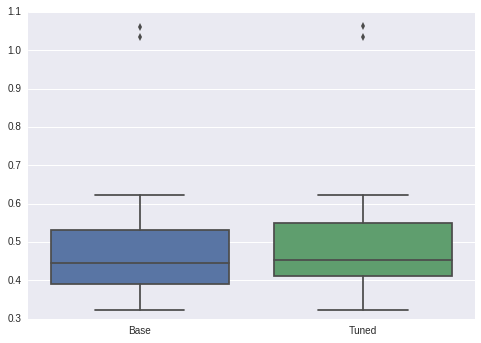

In [146]:
sns.boxplot(scoresDF)

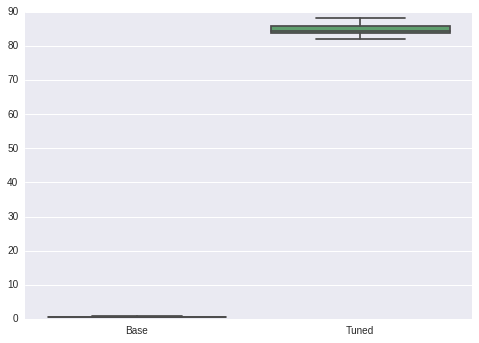

In [141]:
sns.boxplot(timesDF)

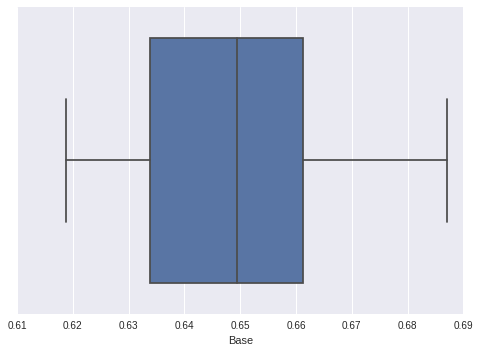

In [148]:
sns.boxplot(timesDF.Base)

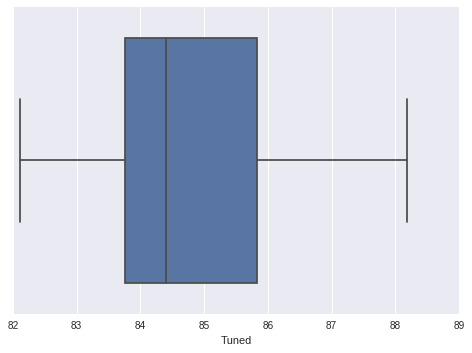

In [149]:
sns.boxplot(timesDF.Tuned)

In [145]:
timesDF.Base.mean()

0.6497844499999246

In [147]:
timesDF.Tuned.mean()

84.56693535000002

In [150]:
pickle.dump(timesDF,open("timesDF.p","wb"))
pickle.dump(timesDF,open("scoresDF.p","wb"))

## Conclusion
While both models have comparable RMSE values, there is a huge difference between the times taken for the 2 models.
Therefore, the basic popularity recommender should be used instead of the tuned factorisation recommender.

## Reflection

To recap the process:
1. Obtain data from Kaggle
2. Process the data
    1. Remove duplicate rows
    2. Add genre information (Create the genre information table)
    3. Remove the 19 games which weren’t in the IGDB database
3. Create scoring function
4. Create benchmark popularity recommender model
5. Create suggested factorisation recommender model
6. Perform hyper-parameter tuning to get tuned factorisation recommender.
7. Evaluate the 3 models on the test dataset
8. Check the robustness of the models and suggest the final model

Defining the scoring function (and implementing it correctly) was the main issue due to the various joins and merges of the dataset. The 12 duplicate rows were one of the biggest roadblocks in this project. I only realised this issue when I was implementing the scoring function and the rows weren’t matching (as detailed in the appendix of the Jupyter notebook).

Checking the robustness of the 2 models via the pipeline was an interesting job. It showed me that while the 2 models had roughly the equal performances, the time taken to train the models made the basic popularity recommender a clear cut winnre

## Improvements
- Define the scoring function to be a weighted product of both the scores. This could be used by companies to decide what factor they want to focus more on. For example, people who have a high normalised score ie. they are heavy players could be targeted with micro-transaction type games.

- More data! This small dataset had limited interactions. Steam could create a better recommendation engine by using their own data.


## Appendix -  Debugging issue with merge and multiple player-game data¶

**Discovery** - While creating the scoring function, it was observed that the dataset created after an inner merge has more rows than the component datasets.
The personal-ratio dataset had 69276 interactions and the playtime-distribution dataset also had 69276 interactions. It was expected that the merged dataset would also have 69276 rows. But it was observed that the merged dataset had 69300 rows. This [SO question](https://stackoverflow.com/questions/41580249/pandas-merged-inner-join-data-frame-has-more-rows-than-the-original-ones) alerted me to the fact that there might be duplicates in the dataset. I observed that certain player-game combinations had 2 playtime entries instead of just 1 (as I had assumed). These duplicate rows were resulting in the issue observed above.

For example, the user ID 71411882 and the game 'Grand Theft Auto III' had 2 entries. This issue was present in the raw data itself.